In [1]:
import torch
import torch.nn.functional as F
from collections import defaultdict
from temperature_scaling import ModelWithTemperature
import logging
from utils import load_model, load_checkpoint, load_yaml, set_seed, load_pickle
from load_data import load_dataset, load_trainloader, load_testloader
from ensemble import load_checkpoint_config, load_and_calibrate_models, test_ensemble
import glob
import re
import sys
import numpy as np
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

## GPU Section

In [37]:
SCRATCH_PATH = "./scratch"

In [2]:
SCRATCH_PATH = "/scratch/izar/flowers"

In [3]:
!nvidia-smi

Thu May 19 10:18:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 455.23.05    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:86:00.0 Off |                  Off |
| N/A   34C    P0    25W / 250W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  On   | 00000000:D8:00.0 Off |                  Off |
| N/A   

In [39]:
# These need to be written to work with GPU's
logger = logging.getLogger()
logger.setLevel(logging.INFO)

console = logging.StreamHandler()
console.setLevel(logging.INFO)

paths = list(filter(
    lambda x: not re.search('cyc|decay|cosine|112747', x),
    glob.glob(f"{SCRATCH_PATH}/logs/CIFAR100/NCPS_ensemble*/best_model*", recursive=True)
))
print(paths)

configs = list(filter(
    lambda x: not re.search('cyc|decay|cosine|112747', x),
    glob.glob(f"{SCRATCH_PATH}/logs/CIFAR100/NCPS_ensemble*/r_*", recursive=True)
))
print(configs)
# configs = configs * 4

['./scratch/logs/CIFAR100/NCPS_ensemble_mid1_20220529-125255/best_model', './scratch/logs/CIFAR100/NCPS_ensemble_low_20220529-114748/best_model', './scratch/logs/CIFAR100/NCPS_ensemble_mid2_20220529-125301/best_model', './scratch/logs/CIFAR100/NCPS_ensemble_high_20220529-114219/best_model']
['./scratch/logs/CIFAR100/NCPS_ensemble_mid1_20220529-125255/r_ncp_mid.yml', './scratch/logs/CIFAR100/NCPS_ensemble_low_20220529-114748/r_ncp_low.yml', './scratch/logs/CIFAR100/NCPS_ensemble_mid2_20220529-125301/r_ncp_mid2.yml', './scratch/logs/CIFAR100/NCPS_ensemble_high_20220529-114219/r_ncp_high.yml']


In [5]:
# load each model into memory
checkpoint_list, config_list = load_checkpoint_config(paths, configs)

config = config_list[0]
if config.get('seed', -1) != -1:
    seed = config['seed']
else:
    raise ValueError("Must have a seed, otherwise temperature won't be calibrated on the correct validation set.")
set_seed(seed)

# Load Data
train_dataset, test_dataset = load_dataset('CIFAR100', root="/scratch/izar/flowers/.data")

config["dataloader"]["subset"] = True
# Initialize dataloaders
train_loader, valid_loader = load_trainloader(
    train_dataset,
    seed=seed,
    **config["dataloader"],
)

# Initialize dataloaders
test_loader = load_testloader(
    test_dataset,
    batch_size=config['dataloader']['batch_size'],
    num_workers=0,
    shuffle=False,
)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
cuda = torch.cuda.is_available()
device = torch.device('cuda' if cuda else 'cpu')
logging.info(f"Running on: {device}")

# TODO what to do if they don't fit in memory???
temp_models = []
for checkpoint, config in zip(checkpoint_list, config_list):
    model = load_and_calibrate_models(checkpoint, config, device, valid_loader, temperature=True, save=False)
    temp_models.append(model)

INFO:root:Running on: cuda


 [16/16]

INFO:temperature_scaling:Before temperature - NLL: 2.381, ECE: 0.121
INFO:temperature_scaling:Optimal temperature: 1.447
INFO:temperature_scaling:After temperature - NLL: 2.256, ECE: 0.051
INFO:root:Temperature: Parameter containing:
tensor([1.4467], device='cuda:0', requires_grad=True)


 [16/16]

INFO:temperature_scaling:Before temperature - NLL: 2.350, ECE: 0.158
INFO:temperature_scaling:Optimal temperature: 1.491
INFO:temperature_scaling:After temperature - NLL: 2.163, ECE: 0.031
INFO:root:Temperature: Parameter containing:
tensor([1.4914], device='cuda:0', requires_grad=True)


 [16/16]

INFO:temperature_scaling:Before temperature - NLL: 2.594, ECE: 0.133
INFO:temperature_scaling:Optimal temperature: 1.481
INFO:temperature_scaling:After temperature - NLL: 2.413, ECE: 0.046
INFO:root:Temperature: Parameter containing:
tensor([1.4813], device='cuda:0', requires_grad=True)


 [16/16]

INFO:temperature_scaling:Before temperature - NLL: 2.667, ECE: 0.150
INFO:temperature_scaling:Optimal temperature: 1.488
INFO:temperature_scaling:After temperature - NLL: 2.476, ECE: 0.042
INFO:root:Temperature: Parameter containing:
tensor([1.4878], device='cuda:0', requires_grad=True)


In [8]:
correct_list, y_true, ensemble_hat, model_pred, model_softmax = test_ensemble(temp_models, test_loader, device)

 [79/79]

In [11]:
model_df = pd.concat([pd.DataFrame(model_pred), pd.DataFrame(model_softmax)], axis=1)
model_df['y_true'] = y_true
model_df['ensemble_pred'] = ensemble_hat

In [ ]:
names = [p.split('/')[-2][:-16] for p in paths]
rename = {'model_0': names[0],
          'model_1': names[1],
          'model_2': names[2],
          'model_3': names[3]}
model_df.rename(rename, axis=1)

In [51]:
file_path = os.path.join("/scratch/izar/flowers/logs/ensemble", "results_2.pkl")
# os.makedirs("/scratch/izar/flowers/logs/ensemble")
with open(file_path, "wb") as f:
    data = pickle.dump(model_df, f)

## Save / Load Pickle

In [52]:
path = "./scratch/logs/ensemble"
name = "results_2.pkl"
model_df = load_pickle(path, name)

In [54]:
model_df.head()

,NCPS_ensemble_low,NCPS_ensemble_high,NCPS_ensemble_mid2,NCPS_ensemble_mid1,model_0_softmax,model_1_softmax,model_2_softmax,model_3_softmax,y_true,ensemble_pred
0,95,68,95,90,0.029759,0.019113,0.006101,0.033504,49,68
1,65,33,33,68,0.006901,0.315829,0.380262,0.134532,33,33
2,91,69,95,72,0.035074,0.030330,0.025992,0.120889,72,55
3,51,13,51,51,0.111859,0.104291,0.159732,0.203980,51,51
4,23,71,23,71,0.218267,0.597295,0.352247,0.747220,71,71


In [55]:
model_df[model_df['NCPS_ensemble_low'] == model_df['y_true']].shape[0] / model_df.shape[0]

0.4214

In [56]:
model_df[model_df['NCPS_ensemble_high'] == model_df['y_true']].shape[0] / model_df.shape[0]

0.4308

In [57]:
model_df[model_df['NCPS_ensemble_mid2'] == model_df['y_true']].shape[0] / model_df.shape[0]

0.4336

In [58]:
model_df[model_df['NCPS_ensemble_mid1'] == model_df['y_true']].shape[0] / model_df.shape[0]

0.4292

In [59]:
model_df[model_df['ensemble_pred'] == model_df['y_true']].shape[0] / model_df.shape[0]

0.5121

In [61]:
def calc_angle(x, y):
    # shift axis
    x = 1 - x
    y = 1 - y
    theta = np.arctan(x / y)
    angle = np.degrees(theta - np.pi/4)
    
    return angle

In [62]:
model_df['angle_0_1'] = model_df.apply(lambda x: calc_angle(x['model_0_softmax'], x['model_1_softmax']), axis=1)

<AxesSubplot:xlabel='angle_0_1', ylabel='Count'>

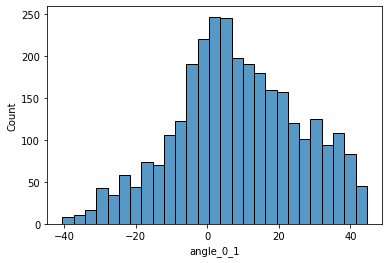

In [63]:
both_correct = model_df[(model_df['NCPS_ensemble_low'] == model_df['y_true']) & (model_df['NCPS_ensemble_high'] == model_df['y_true'])]['angle_0_1']
sns.histplot(both_correct)

<AxesSubplot:xlabel='angle_0_1', ylabel='Count'>

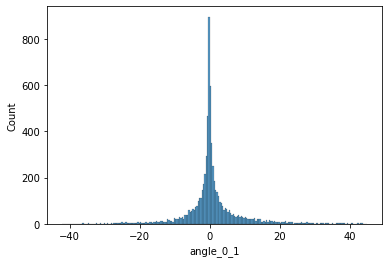

In [64]:
both_incorrect = model_df[~((model_df['NCPS_ensemble_low'] == model_df['y_true']) & (model_df['NCPS_ensemble_high'] == model_df['y_true']))]['angle_0_1']
sns.histplot(both_incorrect)

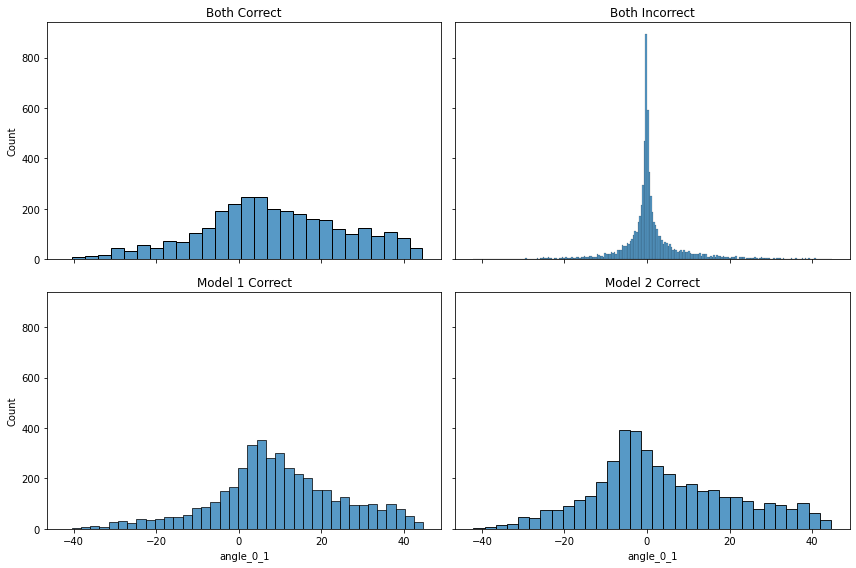

In [86]:
def plot_histograms(model_1, model_2):
    both_correct = model_df[(model_df[model_2] == model_df['y_true']) & (model_df[model_1] == model_df['y_true'])]['angle_0_1']
    both_incorrect = model_df[~((model_df[model_2] == model_df['y_true']) & (model_df[model_1] == model_df['y_true']))]['angle_0_1']
    only_one_correct = model_df[(model_df[model_1] == model_df['y_true'])]['angle_0_1']
    only_other_correct = model_df[(model_df[model_2] == model_df['y_true'])]['angle_0_1']

    fig, ax = plt.subplots(2,2,figsize=(12,8), sharex=True, sharey=True)
    ax[0,0].set_title('Both Correct')
    ax[0,1].set_title('Both Incorrect')
    ax[1,0].set_title('Model 1 Correct')
    ax[1,1].set_title('Model 2 Correct')
    sns.histplot(both_correct, ax=ax[0,0])
    sns.histplot(both_incorrect, ax=ax[0,1])
    sns.histplot(only_one_correct, ax=ax[1,0])
    sns.histplot(only_other_correct, ax=ax[1,1])
    plt.tight_layout()
    plt.show()
plot_histograms('NCPS_ensemble_high', 'NCPS_ensemble_low')

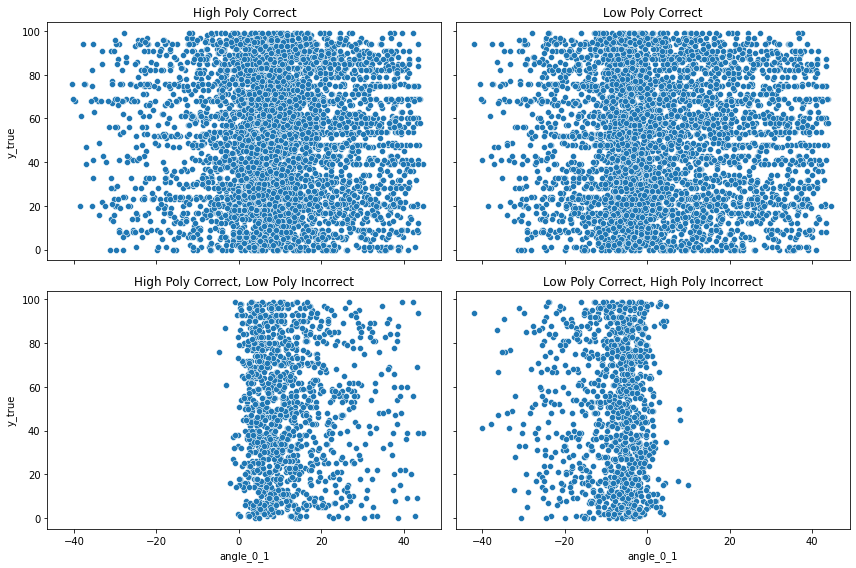

In [80]:
def plot_angles(model_1, model_2):
    one_correct = model_df[model_df['NCPS_ensemble_high'] == model_df['y_true']]
    other_correct = model_df[model_df['NCPS_ensemble_low'] == model_df['y_true']]
    one_only_correct = model_df[(model_df['NCPS_ensemble_high'] == model_df['y_true']) & ~(model_df['NCPS_ensemble_low'] == model_df['y_true'])]
    other_only_correct = model_df[~(model_df['NCPS_ensemble_high'] == model_df['y_true']) & (model_df['NCPS_ensemble_low'] == model_df['y_true'])]

    fig, ax = plt.subplots(2,2,figsize=(12,8), sharex=True, sharey=True)
    ax[0,0].set_title('High Poly Correct')
    ax[0,1].set_title('Low Poly Correct')
    ax[1,0].set_title('High Poly Correct, Low Poly Incorrect')
    ax[1,1].set_title('Low Poly Correct, High Poly Incorrect')
    sns.histplot(both_correct)
    sns.histplot(both_incorrect)
    sns.scatterplot(x= 'angle_0_1', y= 'y_true', data = one_correct, ax=ax[0,0])
    sns.scatterplot(x= 'angle_0_1', y= 'y_true', data = other_correct, ax=ax[0,1])
    sns.scatterplot(x= 'angle_0_1', y= 'y_true', data = one_only_correct, ax=ax[1,0])
    sns.scatterplot(x= 'angle_0_1', y= 'y_true', data = other_only_correct, ax=ax[1,1])
    plt.tight_layout()

## Comparing two networks
## GPU

In [ ]:
from torchvision import transforms
from plots import prepare_images, plot_image_grid
import test
import importlib
importlib.reload(test)

In [ ]:
# paths = list(filter(
#         lambda x: not re.search('xxxx', x),
#         glob.glob(f"{SCRATCH_PATH}/logs/CIFAR10/*poly*/best_model", recursive=True)
#     ))

# configs = list(filter(
#         lambda x: not re.search('xxxx', x),
#         glob.glob(f"{SCRATCH_PATH}/logs/CIFAR10/*poly*/r_resnet_pi-net.yml", recursive=True)
#     ))

In [ ]:
root = "/scratch/izar/flowers/.data"
dataset, y_true, y_pred_list = test.compare_n_nets_by_sample(paths, configs, root=root)

In [ ]:
ind = test.diff_when_wrong_many(y_true, *y_pred_list)

In [ ]:
paths2 = list(filter(
        lambda x: not re.search('162503|160428', x),
        glob.glob(f"{SCRATCH_PATH}/logs/CIFAR10/ResNet*/best_model", recursive=True)
    ))

configs2 = list(filter(
        lambda x: not re.search('xxxx', x),
        glob.glob(f"{SCRATCH_PATH}/logs/CIFAR10/ResNet*/r_resnet_default.yml", recursive=True)
    ))

In [ ]:
paths2

In [ ]:
dataset2, y_true2, y_pred_list2 = compare_n_nets_by_sample(paths2, configs2)

In [ ]:
ind2 = diff_when_wrong_many(y_true2, *y_pred_list2)

In [ ]:
i = diff_when_wrong_many(y_true, y_pred_list[0], y_pred_list2[0])

In [ ]:
i = diff_when_wrong_many(y_true, y_pred_list[1], y_pred_list2[1])

In [ ]:
all_y_pred = [*y_pred_list, *y_pred_list2]

In [ ]:
ind3, model_indices3 = test.diff_when_wrong_many(y_true2, *all_y_pred)

In [ ]:
# transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
unorm = transforms.Normalize(mean=[-0.4914/0.2023, -0.4822/0.1994, -0.4465/0.4465], std=[1/0.2023, 1/0.1994, 1/0.4465])
img_list, label_list, mapping = plots.prepare_images(dataset, model_indices3[(0, 1, 3)][0:36], *all_y_pred, unorm=unorm)
plots.plot_image_grid(img_list, subplot_title=label_list,)